# To Figure Out:  
How to get transforms working without requirings all images from the start  
Figure out GAN Loss and cycle loss  
Will need to edit training loop using iter and next so that I can use one img from each dataset concurrently  


#Dataset

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.utils.spectral_norm as spectral_norm
import torchvision
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from google.colab import files, drive
from sklearn.model_selection import KFold
import math
import itertools
import csv
import os

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Can I can use GPU now? -- {torch.cuda.is_available()}')

Can I can use GPU now? -- True


In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Get list of names for monet painting files
mon_dir = "/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/dataset/Monet"
mon_ann = os.listdir(mon_dir)

# Get list of names for scenery image files
scene_dir = "/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/dataset/Photos"
scene_ann = os.listdir(scene_dir)

In [5]:
print(f"Number of Monet Images: [{len(mon_ann)}] " f"Amount of scenery photos: [{len(scene_ann)}]")

Number of Monet Images: [1185] Amount of scenery photos: [3557]


In [6]:
# Create the dataset:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, directory, annotations, aug=False):
    self.indexed_dataset = [sample for sample in annotations]
    self.image_list = []
    self.dir = directory
    if self.dir[len(self.dir) - 1] != "/":
      self.dir += "/" # Ensures correct spelling
    self.aug = aug
    self.aug_transform = transforms.Compose([transforms.Resize((128, 128)),
                                             transforms.RandomHorizontalFlip(),
                                             transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=(-0.1,0.1)),
                                             transforms.ToTensor()])
    self.desaturate = transforms.Lambda(lambda x: torchvision.transforms.functional.adjust_saturation(x, 0.5))
    idx = 0
    if self.aug == True:
      for i in range(len(self.indexed_dataset) * 2):
        idx += 1
        if (idx >= len(self.indexed_dataset)):
          idx = idx % (len(self.indexed_dataset))
        if (idx%500 == 0):
          print(idx)
        self.image_list.append(self.get_image_tensor(idx))
    else:
      for i in range(len(self.indexed_dataset)):
        if (i%500 == 0):
          print(i)
        self.image_list.append(self.desaturate(self.get_image_tensor(i)))

  def get_image_tensor(self, idx):
    img = Image.open(self.dir + self.indexed_dataset[idx])
    if (img.mode != "RGB"):
      print("ERROR B&W IMAGE: ", self.indexed_dataset[idx])
    return self.aug_transform(img)


  def __len__(self):
    if self.aug:
      return len(self.indexed_dataset) * 2
    else:
      return len(self.indexed_dataset)

  def __getitem__(self, idx): 
    return self.image_list[idx]

# ------------------------
# Define dataset:
# ------------------------

# Monet Paintings:
monet_dataset = MyDataset(mon_dir, mon_ann, aug=True)

# Scene Images:
scene_dataset = MyDataset(scene_dir, scene_ann[0:2400], aug=False)

500
1000
0
500
1000
0
0
500
1000
1500
2000


In [7]:
print(f"Number of Monet dataset: [{len(monet_dataset)}] " f"Amount of scenery dataset: [{len(scene_dataset)}]")

Number of Monet dataset: [2370] Amount of scenery dataset: [2400]


In [8]:
def display_fake_real_tensor_image(fake_tensor, real_tensor):
  transform = transforms.Compose([transforms.Normalize(mean=[-1.0, -1.0, -1.0], std=[2.0, 2.0, 2.0]),
                                  transforms.ToPILImage()])
  real_tensor = real_tensor.squeeze()
  transform(real_tensor).show()

  # Print generated monet:
  fake_tensor = fake_tensor.squeeze()
  transform(fake_tensor).show()

def display_fake_real_tensor_image_no_transform(fake_tensor, real_tensor):
  transform = transforms.Compose([transforms.ToPILImage()])
  real_tensor = real_tensor.squeeze()
  transform(real_tensor).show()

  # Print generated monet:
  fake_tensor = fake_tensor.squeeze()
  transform(fake_tensor).show()

def lr_lambda(epoch):
  if epoch < 100:
    # Keep learning rate constant for 100 epochs
    return 1
  else:
    # Scale linearly to 0 over next n epochs
    return 1 - (epoch-50)/50

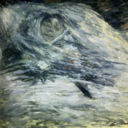

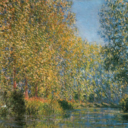

In [9]:
display_fake_real_tensor_image_no_transform(monet_dataset[1183], monet_dataset[1183*2+1])

#W-GANS

In [10]:
# As recommended in my paper, I built my resnet block loosely on the implementation from: https://github.com/jcjohnson/fast-neural-style
class ResNetBlock(nn.Module):
  def __init__(self, in_ch, out_ch, bias=False, dropout=False):
    super(ResNetBlock, self).__init__()
    assert in_ch == out_ch, "Resnet block needs equal in_ch and out_ch"

    convolution_head = []
    convolution_head += [nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, stride =1, bias=bias),
                         nn.BatchNorm2d(out_ch),
                         nn.ReLU(True)]
    if dropout == True:
      convolution_head += [nn.Dropout(0.5)]
    convolution_head += [nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, stride =1, bias=bias),
                         nn.BatchNorm2d(out_ch)]
    self.conv_head = nn.Sequential(*convolution_head)

    for layer in self.conv_head:
      if isinstance(layer, nn.Conv2d):
        nn.init.normal_(layer.weight, mean=0.0, std=0.02)
      elif isinstance(layer, nn.BatchNorm2d):
        nn.init.normal_(layer.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(layer.bias.data, val=0.0)

  def forward(self, x):
    out = x + self.conv_head(x)
    return out


Latent will be of size 64
changed resnet kernel_size=3, padding=1, stride=0 to kernel_size=3, padding=2, stride =1  
changed first conv2d to have output_padding of 1 to keep even numbers  

In [11]:
# W-GAN Network based on U-NET architecture which employs the use of skip connections through ResNet layers
# Bias is kept as false due to limited training data
class Generator(nn.Module):
  def __init__(self, num_resnet=6, bias=False, dropout=False):
    super(Generator, self).__init__()
    base_num_filters = 64
    model = []
    # Image to latent representation:
    model += [nn.ReflectionPad2d(3), # Ensures no change to data size
              nn.Conv2d(3, base_num_filters, kernel_size=7, padding=0, bias=bias),
              nn.BatchNorm2d(base_num_filters, eps=1e-5), # Ensure eps is set since we will use batch_size=1
              nn.LeakyReLU(0.2, False)]

    # Downsampling layers (from 64->128->256->512)
    # Could try normal ReLU instead of LeakyReLU
    num_downsampling = 3
    for i in range(num_downsampling):
      filter_mult = 2 ** i
      model += [nn.Conv2d(base_num_filters * filter_mult, base_num_filters * filter_mult * 2, kernel_size=3, stride=2, padding=1, bias=bias),
                nn.BatchNorm2d(base_num_filters * filter_mult * 2, eps=1e-5),
                nn.LeakyReLU(0.2, True)]

    num_ch = base_num_filters * 2**num_downsampling
    for i in range(num_resnet):
      model += [ResNetBlock(num_ch, num_ch, bias, dropout)]

    # Go back down in channel size: 512->256->128->64
    # Upsampling is done using Transpose Convolutions
    num_upsampling = 3
    for i in range(num_upsampling):
      filter_mult = 2 ** (num_upsampling - i)
      model += [nn.ConvTranspose2d(base_num_filters * filter_mult, int((base_num_filters * filter_mult) / 2), kernel_size=3, stride=2, padding=1, output_padding=1, bias=bias),
                nn.BatchNorm2d(int((base_num_filters * filter_mult) / 2), eps=1e-5),
                nn.LeakyReLU(0.2, False)]

    # Latent representation back to image:
    model += [nn.ReflectionPad2d(3),
            nn.Conv2d(base_num_filters, 3, kernel_size=7, padding=0, bias=bias),
            nn.Tanh()] # Finish with Tanh as recommended in paper

    # Output image size should be of (1,3,H,W) where H,W come from input image
    self.generator_head = nn.Sequential(*model)

    # Initialize model paramaters:
    for layer in self.generator_head:
      if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.ConvTranspose2d):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
      elif isinstance(layer, nn.BatchNorm2d):
        nn.init.normal_(layer.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(layer.bias.data, val=0.0)


  def forward(self, x):
    return self.generator_head(x)

In [12]:
# Critic
# Follows critic architecture from W-GAN paper
class Critic(nn.Module):
  def __init__(self, num_resnet=0, dropout=False, bias=nn.InstanceNorm2d):
    super(Critic, self).__init__()

    base_num_filters = 64
    model = []
    model += [nn.Conv2d(3, base_num_filters, kernel_size=3, stride=2, padding=1), 
              nn.LeakyReLU(0.2, True)]
    num_downsampling = 3
    for i in range(num_downsampling):
      filter_mult = 2 ** i
      model += [nn.Conv2d(base_num_filters * filter_mult, base_num_filters * filter_mult * 2, kernel_size=4, stride=2, padding=1, bias=bias),
                nn.BatchNorm2d(base_num_filters * filter_mult * 2, eps=1e-5),
                nn.LeakyReLU(0.2, True)]

    num_ch = base_num_filters * 2**num_downsampling
    #for i in range(num_resnet):
    #  # I want to test the effect of adding resnet blocks in critic structure
    #  model += [ResNetBlock(num_ch, num_ch, bias=False, dropout=dropout)]

    model += [nn.Conv2d(num_ch, num_ch, kernel_size=4, stride=1, padding=1, bias=bias),
              nn.BatchNorm2d(num_ch, eps=1e-5),
              nn.LeakyReLU(0.2, True)]


    model += [nn.Conv2d(num_ch, 1, kernel_size=4, stride=1, padding=1),
              nn.Flatten(), 
              nn.Linear(36,1)]
    self.critic_head = nn.Sequential(*model)

    for layer in self.critic_head:
      if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
        nn.init.kaiming_normal_(layer.weight, nonlinearity='leaky_relu')
        if layer.bias is not None:
          nn.init.constant_(layer.bias, 0.0)
      elif isinstance(layer, nn.BatchNorm2d):
        nn.init.normal_(layer.weight.data, mean=1.0, std=0.02)
        nn.init.constant_(layer.bias.data, val=0.0)

  def forward(self, x):
    return self.critic_head(x)

#Training

Training details We apply two techniques from recent
works to stabilize our model training procedure.  
First, for LGAN (Equation 1), we replace the negative log likelihood objective by a least-squares loss [35]. This loss is
more stable during training and generates higher quality
results.  
  

In particular, for a GAN loss LGAN(G, D, X, Y ),
we train the G to minimize Ex∼pdata(x)
[(D(G(x)) − 1)2
]
and train the D to minimize Ey∼pdata(y)
[(D(y) − 1)2
] +
Ex∼pdata(x)
[D(G(x))2
].  
  
Second, to reduce model oscillation [15], we follow
Shrivastava et al.’s strategy [46] and update the discriminators using a history of generated images rather than the
ones produced by the latest generators. We keep an image
buffer that stores the 50 previously created images.  
  

For all the experiments, we set λ = 10 in Equation 3.
We use the Adam solver [26] with a batch size of 1. All
networks were trained from scratch with a learning rate of
0.0002.  
  
  We keep the same learning rate for the first 100
epochs and linearly decay the rate to zero over the next 100
epochs. Please see the appendix (Section 7) for more details
about the datasets, architectures, and training procedures.

In [13]:
def gradient_penalty(discriminator, real_images, fake_images):
    batch_size = real_images.size(0)
    device = real_images.device
    alpha = torch.rand(batch_size, 1, 1, 1, device=device)
    interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
    d_interpolates = discriminator(interpolates)
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates,
                                    grad_outputs=torch.ones_like(d_interpolates),
                                    create_graph=True, retain_graph=True)[0]
    gradient_penalty = ((gradients.view(batch_size, -1).norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [14]:
# Loss is L_Gan1 + L_Gan2 + lambda * Loss_cyc(G, F)
# Initialize Hyper-parameters:
batch_size=1
lr=2e-4
epochs=50
lambda_cyc=12
lambda_grad_pen=10

# Initialize networks
gen_S2M = Generator().to(device) # Generates images from scenery to monet
critic_M = Critic().to(device)   # Critic to determine real or fake monet

gen_M2S = Generator().to(device) # Generates images from monet to scenery
critic_S = Critic().to(device)   # Critic to determine real or fake scenery

# Initialize optimizers:
gen_optim = torch.optim.Adam(list(gen_S2M.parameters()) + list(gen_M2S.parameters()), lr=lr, betas=(0.9, 0.999))
crit_optim = torch.optim.Adam(list(critic_M.parameters()) + list(critic_S.parameters()), lr=lr, betas=(0.9, 0.999))

# Initialize Learning_Rate scheduler:
gen_scheduler = torch.optim.lr_scheduler.LambdaLR(gen_optim, lr_lambda=lr_lambda)
C_scheduler = torch.optim.lr_scheduler.LambdaLR(crit_optim, lr_lambda=lr_lambda)

# Initialize DataLoaders:
monet_loader = DataLoader(monet_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
scene_loader = DataLoader(scene_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# Initialize Losses:
Cyc_Loss = nn.L1Loss()
Identity_Loss = nn.L1Loss()
GAN_MSE_Loss = nn.MSELoss(reduction='mean')
S_MSE_Loss = nn.MSELoss(reduction='mean')
M_MSE_Loss = nn.MSELoss(reduction='mean')

# Target and fake labels:
one = torch.ones(batch_size, 1, device=device)
zero = torch.zeros(batch_size, 1, device=device)

G_losses = []
C_losses = []
gen_iter = 0
clipping_threshold = 0.01


for epoch in range(epochs):
  monet_iter = iter(monet_loader)
  scene_iter = iter(scene_loader)

  i = 0
  while i < len(monet_loader):
    i += 1
    # Ensure critic has requires_grad (I turn it off later when training gen)
    for param in critic_M.parameters():
      param.requires_grad = True
    for param in critic_S.parameters():
      param.requires_grad = True

    # Get input data:
    real_monet = next(monet_iter).to(device)
    real_scene = next(scene_iter).to(device)
    batch_size = real_scene.size(0) # Ensures correct batching

    # ******************************
    # Train Critics:
    # ******************************
    # -------------------------------------------
    # Train Critic from Monet to Scenery:
    # -------------------------------------------
    # Train with real monet images:
    crit_optim.zero_grad()
    critic_real_monet = critic_M(real_monet)

    # Train with fake monet images
    fake_monet = gen_S2M(real_scene)
    critic_fake_monet = critic_M(fake_monet)

    # Loss and backward functions:
    Loss_M = M_MSE_Loss(critic_real_monet, one) + M_MSE_Loss(critic_fake_monet, zero) + lambda_grad_pen * gradient_penalty(critic_M, real_monet, fake_monet)

    # -------------------------------------------
    # Train Critic from Monet to Scenery:
    # -------------------------------------------
    # Train with real monet images:
    critic_real_scene = critic_S(real_scene)

    # Train with fake monet images
    fake_scene = gen_M2S(real_monet)
    critic_fake_scene = critic_S(fake_scene)
    Loss_S = S_MSE_Loss(critic_real_scene, one) + S_MSE_Loss(critic_fake_scene, zero) + lambda_grad_pen * gradient_penalty(critic_S, real_scene, fake_scene)
    critic_loss = Loss_M * 0.5 + Loss_S *0.5
    critic_loss.backward()
    crit_optim.step()

    # ******************************
    # Finish Train Critics:
    # ******************************


    # ******************************
    # Train Generators:
    # ******************************
    for param in critic_M.parameters():
      param.requires_grad = False
    for param in critic_S.parameters():
      param.requires_grad = False
    gen_optim.zero_grad()

    # Monet Gen:
    critic_real_monet_2 = critic_M(real_monet)
    fake_monet_2 = gen_S2M(real_scene)
    critic_fake_monet_2 = critic_M(fake_monet_2)

    # Scene Gen:
    critic_real_scene_2 = critic_M(real_scene)
    fake_scene_2 = gen_M2S(real_monet)
    critic_fake_scene_2 = critic_S(fake_scene_2)

    # Full Objective Function
    L_GAN_M = GAN_MSE_Loss(critic_fake_monet_2, one)
    L_GAN_S = GAN_MSE_Loss(critic_fake_scene_2, one)
    L_Cyc = Cyc_Loss(gen_S2M(fake_scene_2), real_monet) + Cyc_Loss(gen_M2S(fake_monet_2), real_scene)
    L_Identity = Identity_Loss(fake_monet_2, real_monet) + Identity_Loss(fake_scene_2, real_scene)
    loss = L_GAN_M + L_GAN_S + lambda_cyc * L_Cyc + L_Identity * 0.5 * lambda_cyc
    loss.backward()
    gen_optim.step()
  
    gen_iter += 1

    # Print out results:
    if i % 1000 == 0:
      print(f"[lr: {lr}] " f"[Epoch {epoch+1}/{epochs}] " f"[iter {i+1}/{len(monet_loader)}] "
            f"[Critic Loss: {critic_loss.item():.4f}] " f"[G loss: {loss.item():.4f}]")

      # Print real scenery:
      display_fake_real_tensor_image_no_transform(fake_monet_2, real_scene)
      G_losses.append(loss.item())
      C_losses.append(critic_loss.item())

  # Update learning rate depending on the epoch
  gen_scheduler.step()
  C_scheduler.step()


Output hidden; open in https://colab.research.google.com to view.

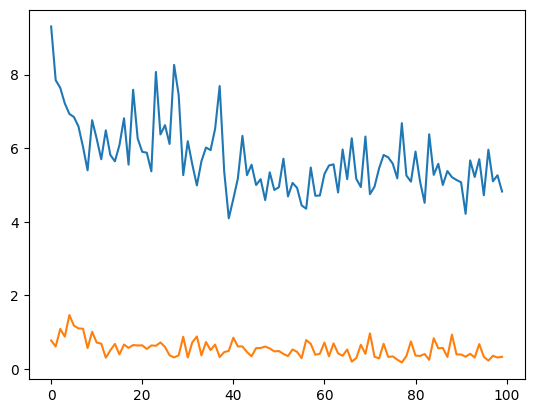

In [15]:
x_vals = range(len(G_losses))
x_vals2 = range(len(C_losses))
plt.plot(x_vals, G_losses)
plt.plot(x_vals2, C_losses)
plt.show()

In [16]:
# Notes
# Added lambda_cyc * LCyc (hopefully will help to improve training)

# Next hyper-parameters to try:
# 1: lr = 0.0002 for 100 epochs then linearly scaling down to 0 for 100 epochs
# 2: n_critic = 200 for start
# 3: Change hyper-parameters related to data augmentation of what monet is (try without it?)
# Want to try from 3 gen 2 C, to 9gen 7 C
# Want to try base_num_filters 64->128 (meant to improve the output image quality)

In [17]:
#### TODO
# Need to implement adverserial loss for L_GAN? (shown below is the function required) 
# Review W-GAN from lecture
# LGAN is least squares loss
# Need to implement L_identity


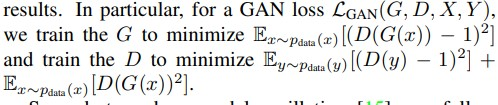

#Testing

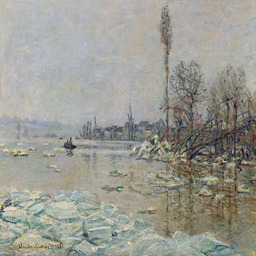

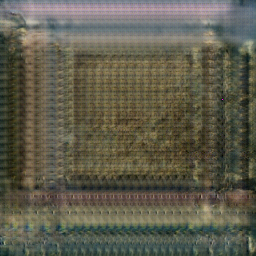

In [18]:
image_filepath = "/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/dataset/Monet/" + mon_ann[0]
to_tensor = transforms.Compose([transforms.ToTensor()])
img = Image.open(image_filepath)
if (img.mode != "RGB"):
  img = img.convert('RGB')
img_monet = to_tensor(img)

gen_M2S.to('cpu')
fake_scene = gen_M2S(img_monet.unsqueeze(dim=0))
display_fake_real_tensor_image_no_transform(fake_scene, img_monet)

In [19]:
def print_monet_comparison(idx):
  image_filepath = "/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/dataset/Photos/" + scene_ann[idx]
  to_tensor = transforms.Compose([transforms.ToTensor()])
  img = Image.open(image_filepath)
  if (img.mode != "RGB"):
    img = img.convert('RGB')
  img_scene = to_tensor(img)

  gen_S2M.to('cpu')
  fake_monet = gen_S2M(img_scene.unsqueeze(dim=0))
  display_fake_real_tensor_image_no_transform(fake_monet, img_scene)

In [20]:
for i in range(25):
  print_monet_comparison(i)

Output hidden; open in https://colab.research.google.com to view.

In [21]:
from skimage import color, exposure

def display_for_output(idx):
  image_filepath = "/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/dataset/Photos/" + scene_ann[idx]
  to_tensor = transforms.Compose([transforms.ToTensor()])
  transform2 = transforms.ToPILImage()
  img = Image.open(image_filepath)
  if (img.mode != "RGB"):
    img = img.convert('RGB')
  img_scene = to_tensor(img)

  gen_S2M.to('cpu')
  fake_monet = gen_S2M(img_scene.unsqueeze(dim=0))

  monet_image = fake_monet.squeeze()
  monet_image = transform2(monet_image)

  img1_lab = color.rgb2lab(img)
  img2_lab = color.rgb2lab(monet_image)

  img2_matched = exposure.match_histograms(img2_lab, img1_lab)

  img2_matched = color.lab2rgb(img2_matched)
  img_monet_matched = to_tensor(img2_matched)

  display_fake_real_tensor_image_no_transform(img_monet_matched, img_scene)

In [22]:
for i in range(25):
  display_for_output(i)

Output hidden; open in https://colab.research.google.com to view.

# Save model parameters:

In [23]:
torch.save(gen_S2M.state_dict(), '/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/Saved_Models/NoSpectralNorm/gen_S2M_Desat.pth')
torch.save(gen_M2S.state_dict(), '/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/Saved_Models/NoSpectralNorm/gen_M2S_Desat.pth')
torch.save(critic_S.state_dict(), '/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/Saved_Models/NoSpectralNorm/critic_S_Desat.pth')
torch.save(critic_M.state_dict(), '/content/drive/MyDrive/Colab Notebooks/ECE50024/Project/Saved_Models/NoSpectralNorm/critic_M_Desat.pth')